## Imports

In [1]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms, models
import torch
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

sys.path.insert(0, '../src')

import models
import util

# Utility functions playground

(40, 40, 3)
20.184434256132867


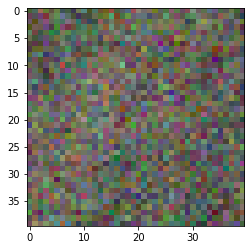

In [10]:
image = np.asarray(Image.open('../data/test/8023.jpg'))
# _, noise = util.addNoise(transforms.PILToTensor()(image), 0.5)
# image = transforms.PILToTensor()(image)
patch_size = 40
H, W = image.shape[:2]
rnd_h = random.randint(0, max(0, H - patch_size))
rnd_w = random.randint(0, max(0, W - patch_size))

image = image[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :]

def float2tensor(img):
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float()

def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

noisy, noise = util.addNoise(image)
# plt.imshow(tensor2uint(noisy))
plt.imshow(image)
print(util.calcPSNR(noisy, noisy - noise))

# Training playground

### Declarations

In [3]:
train_dir = "../data/train"
test_dir = "../data/test"

patch_size = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# create train and test dataset
train_dataset = models.ImageDataset(train_dir)
test_dataset = models.ImageDataset(test_dir)

# batch size
batch_size = 16

# create train and test dataloader
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# model declaration and hyperparameters
model = models.DnCNN().to(device)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr)

### Train

In [5]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader, 1):
        target = data
        input, noise = util.addNoise(target, 25)
        
        input = Variable(input.cuda())
        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        
        output = model(input)

        loss = criterion(output, noise)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

### Validate

In [6]:
def validate():
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for data in testing_data_loader:
            target = data
            input, noise = util.addNoise(target, 25)

            input = Variable(input.cuda())
            noise = Variable(noise.cuda())
            target = Variable(target.cuda())

            output = model(input)
            # mse = criterion(output, input)
            # psnr = 10 * log10(1 / mse.item())
            psnr = util.calcPSNR(output, input)
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

### Save model

In [7]:
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

### Training loop

In [8]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
      validate()
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

torch.Size([16, 40, 40, 3])


/home/jonda/.local/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:64: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return default_collate([torch.as_tensor(b) for b in batch])


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.